In [ ]:
## Notebook env: brian_script_env (R kernel)
## here we compare the 4 guide fractions from CRISPRa and the 1 guide fraction from CRISPRi for their diversity of guides per cell
## we will make a histogram for each fraction (total 5)
## each histogram will contain the guide diversity scores for cells in that fraction
## guide diversity scores for each cell calculated as follows: (1 - proportion of guide 1 UMI) * (1 - proportion of guide 2 UMI) * ... * (1 - proportion of guide N UMI)
## the lower the guide diversity score, the more homogenous the guides are in that cell

## Guide diversity by guide diversity scores

In [1]:
## load in guide fraction UMI per barcode data
## only loading for GEM1 for all 5 fractions

# CRISPRa
CRISPRa_072623 = read.csv('/home/ssobti/projects/heterogeneity_brian/data/072623_MD231_CRISPRa_repeat_screen/cellranger/GEM1_CRISPRa_BC_untethered/outs/crispr_analysis/protospacer_calls_per_cell.csv')
CRISPRa_072623_300bp = read.csv('/home/ssobti/projects/heterogeneity_brian/data/101323_MD231_CRISPRa_guide_fraction_miseq/cellranger/GEM1_CRISPRa_BC_untethered/outs/crispr_analysis/protospacer_calls_per_cell.csv')
CRISPRa_072623_400bp = read.csv('/home/ssobti/projects/heterogeneity_brian/data/072623_MD231_CRISPRa_guide_fraction_miseq/cellranger/GEM1_CRISPRia_BC_untethered/outs/crispr_analysis/protospacer_calls_per_cell.csv')
CRISPRa_032923 = read.csv('/home/ssobti/projects/heterogeneity_brian/data/032923_MD231_CRISPRi_CRISPRa_screen/230329_A01102_0587_AH3CY5DSX7_S4_200/cellranger/GEM3_CRISPRa_BC_untethered/outs/crispr_analysis/protospacer_calls_per_cell.csv')
CRISPRi_032923 = read.csv('/home/ssobti/projects/heterogeneity_brian/data/032923_MD231_CRISPRi_CRISPRa_screen/230329_A01102_0587_AH3CY5DSX7_S4_200/cellranger/GEM1_CRISPRi/outs/crispr_analysis/protospacer_calls_per_cell.csv')

guide_fractions = list(CRISPRa_072623, CRISPRa_072623_300bp, CRISPRa_072623_400bp, CRISPRa_032923, CRISPRi_032923)
names(guide_fractions) = c('CRISPRa_072623', 'CRISPRa_072623_300bp', 'CRISPRa_072623_400bp', 'CRISPRa_032923', 'CRISPRi_032923')

get_guide_diversity_scores = function(input_df) {
    total_umi_per_cell = lapply(X = stringr::str_split(input_df$num_umis, stringr::fixed('|')), FUN = function(x) sum(as.numeric(x)))
    umis_per_cell = lapply(stringr::str_split(input_df$num_umis, stringr::fixed('|')), as.numeric)
    guide_diversity_scores = as.numeric(mapply(FUN = function(x, y) return(prod(1 - (y/x))), x = total_umi_per_cell, y = umis_per_cell, SIMPLIFY = FALSE))
    return(guide_diversity_scores)
}

In [2]:
diversity_scores = lapply(guide_fractions, get_guide_diversity_scores)
diversity_score_dfs = lapply(diversity_scores, function(x) return(data.frame(scores = x)))

In [3]:
library(ggplot2)
library(ggpubr)
plots = mapply(FUN = function(data, title){return(ggplot(data, aes(x = scores)) + geom_histogram(color = "black", fill = "white") + ggtitle(title) + theme(plot.title = element_text(hjust = 0.5)))}, data = diversity_score_dfs, title = names(diversity_score_dfs), SIMPLIFY = FALSE)

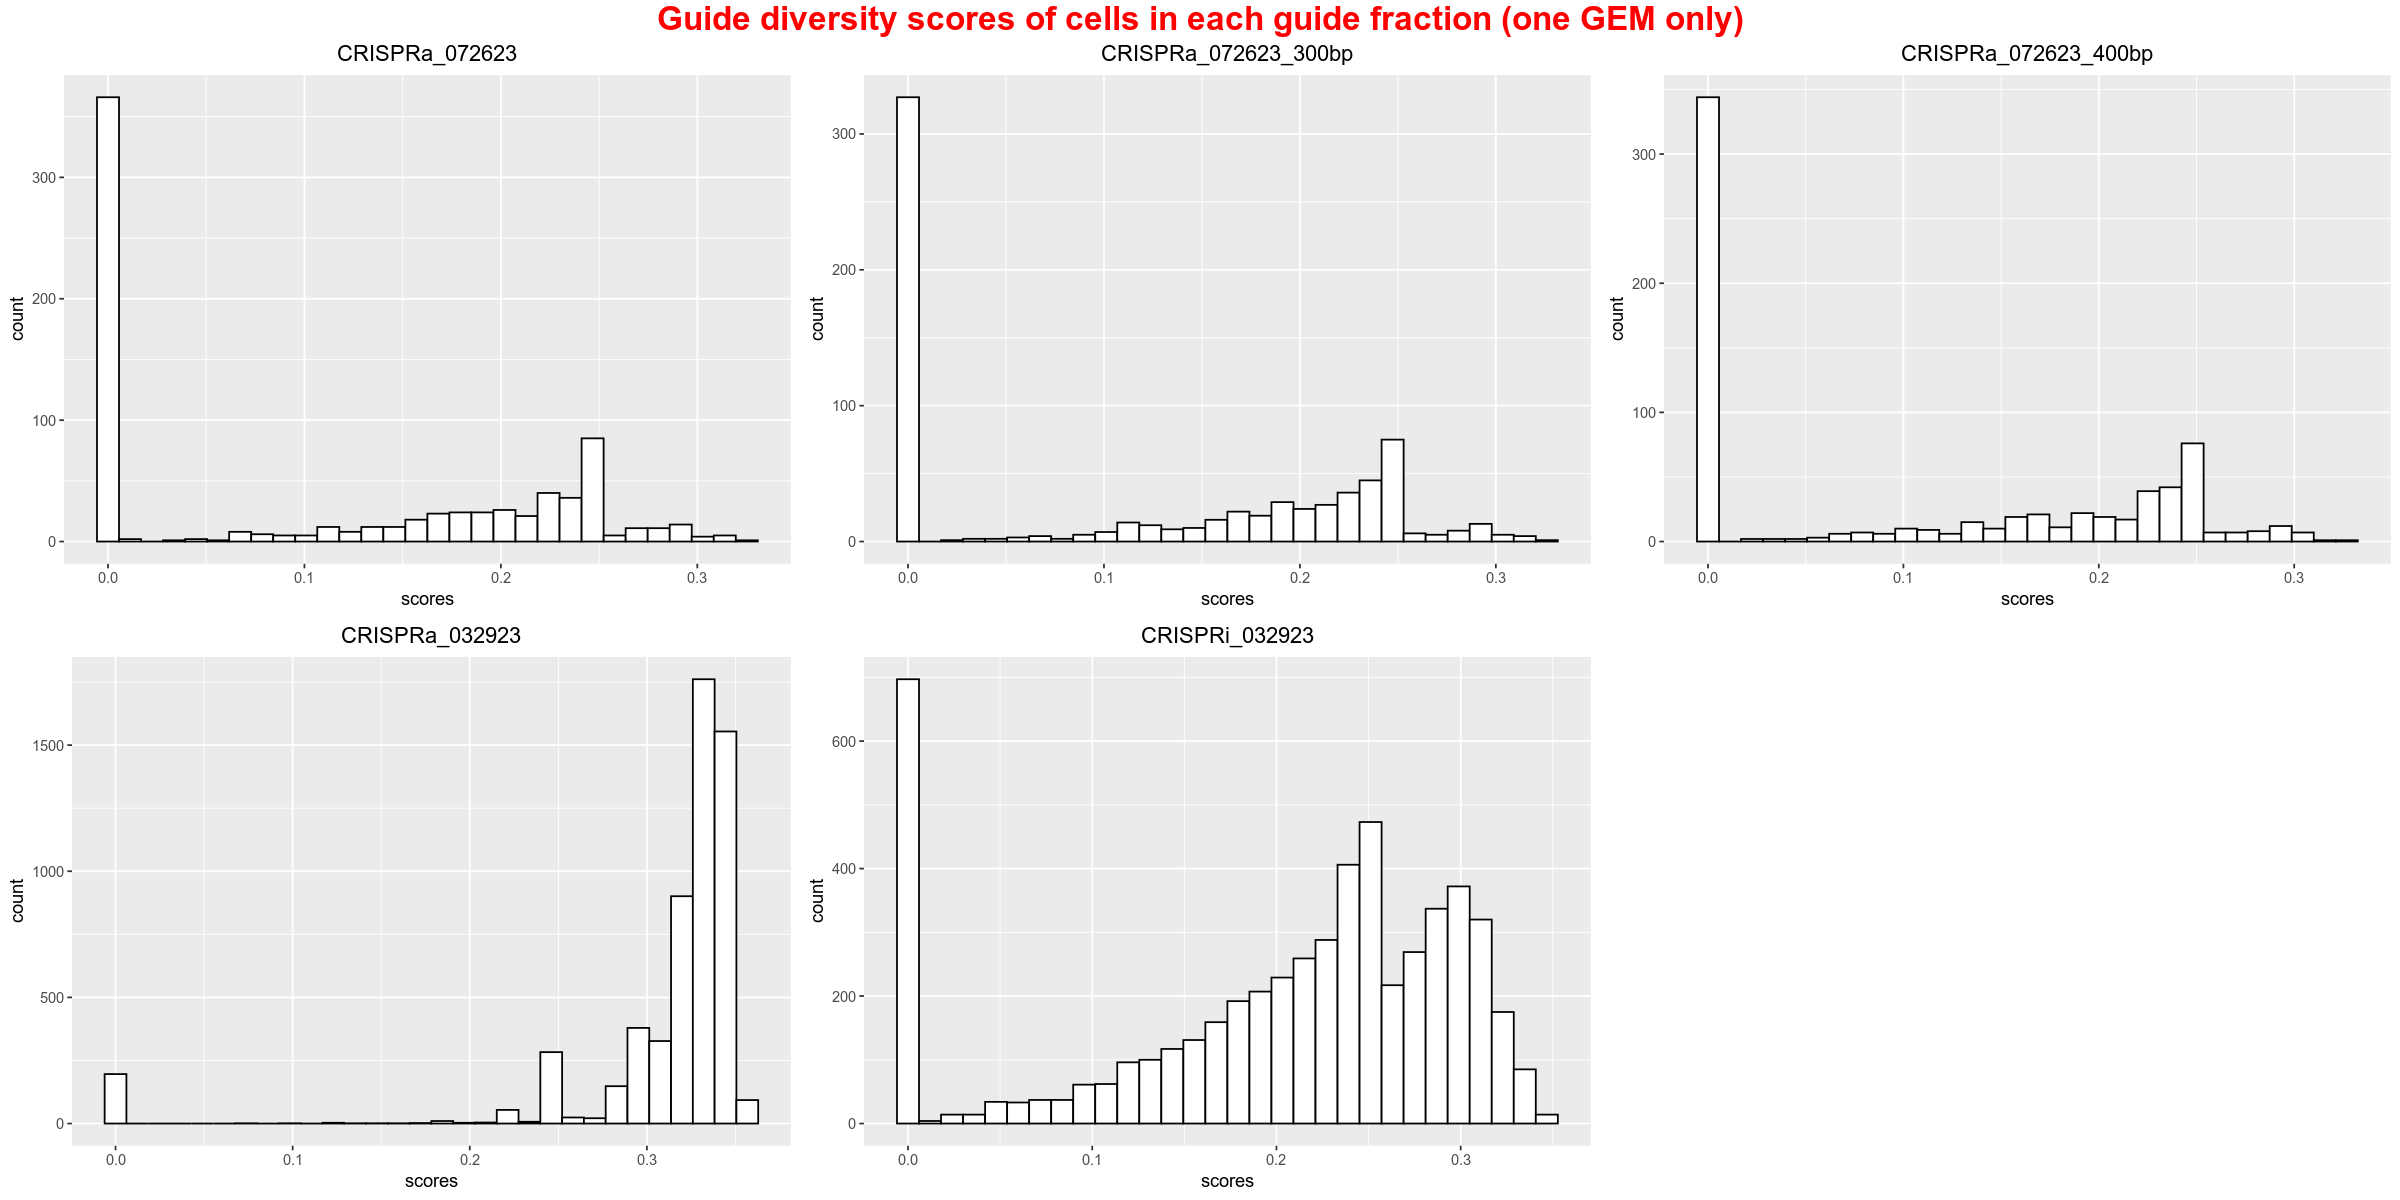

In [4]:
## histogram of guide diversity scores of cells in each guide fraction
## extremely low guide diversity score means mostly one guide in a cell
options(repr.plot.width = 20, repr.plot.height = 10)
plot = suppressMessages(ggarrange(plotlist = plots, ncol = 3, nrow = 2))
suppressMessages(annotate_figure(plot, top = text_grob("Guide diversity scores of cells in each guide fraction (one GEM only)", 
               color = "red", face = "bold", size = 20)))

## Guide diversity by total UMI counts per guide

In [5]:
get_umis_per_guide = function(input_df) {
    filtered_df = input_df %>% dplyr::select(feature_call, num_umis)
    guides = lapply(stringr::str_split(input_df$feature_call, stringr::fixed('|')), as.character)
    umis = lapply(stringr::str_split(input_df$num_umis, stringr::fixed('|')), as.numeric)
    new_df = data.frame(guides = unlist(guides), umis = unlist(umis))
    summed_df = new_df %>% dplyr::group_by(guides) %>% dplyr::summarise(umis = sum(umis))
    return(summed_df)
}

In [6]:
total_umis_per_guide = lapply(guide_fractions, get_umis_per_guide)

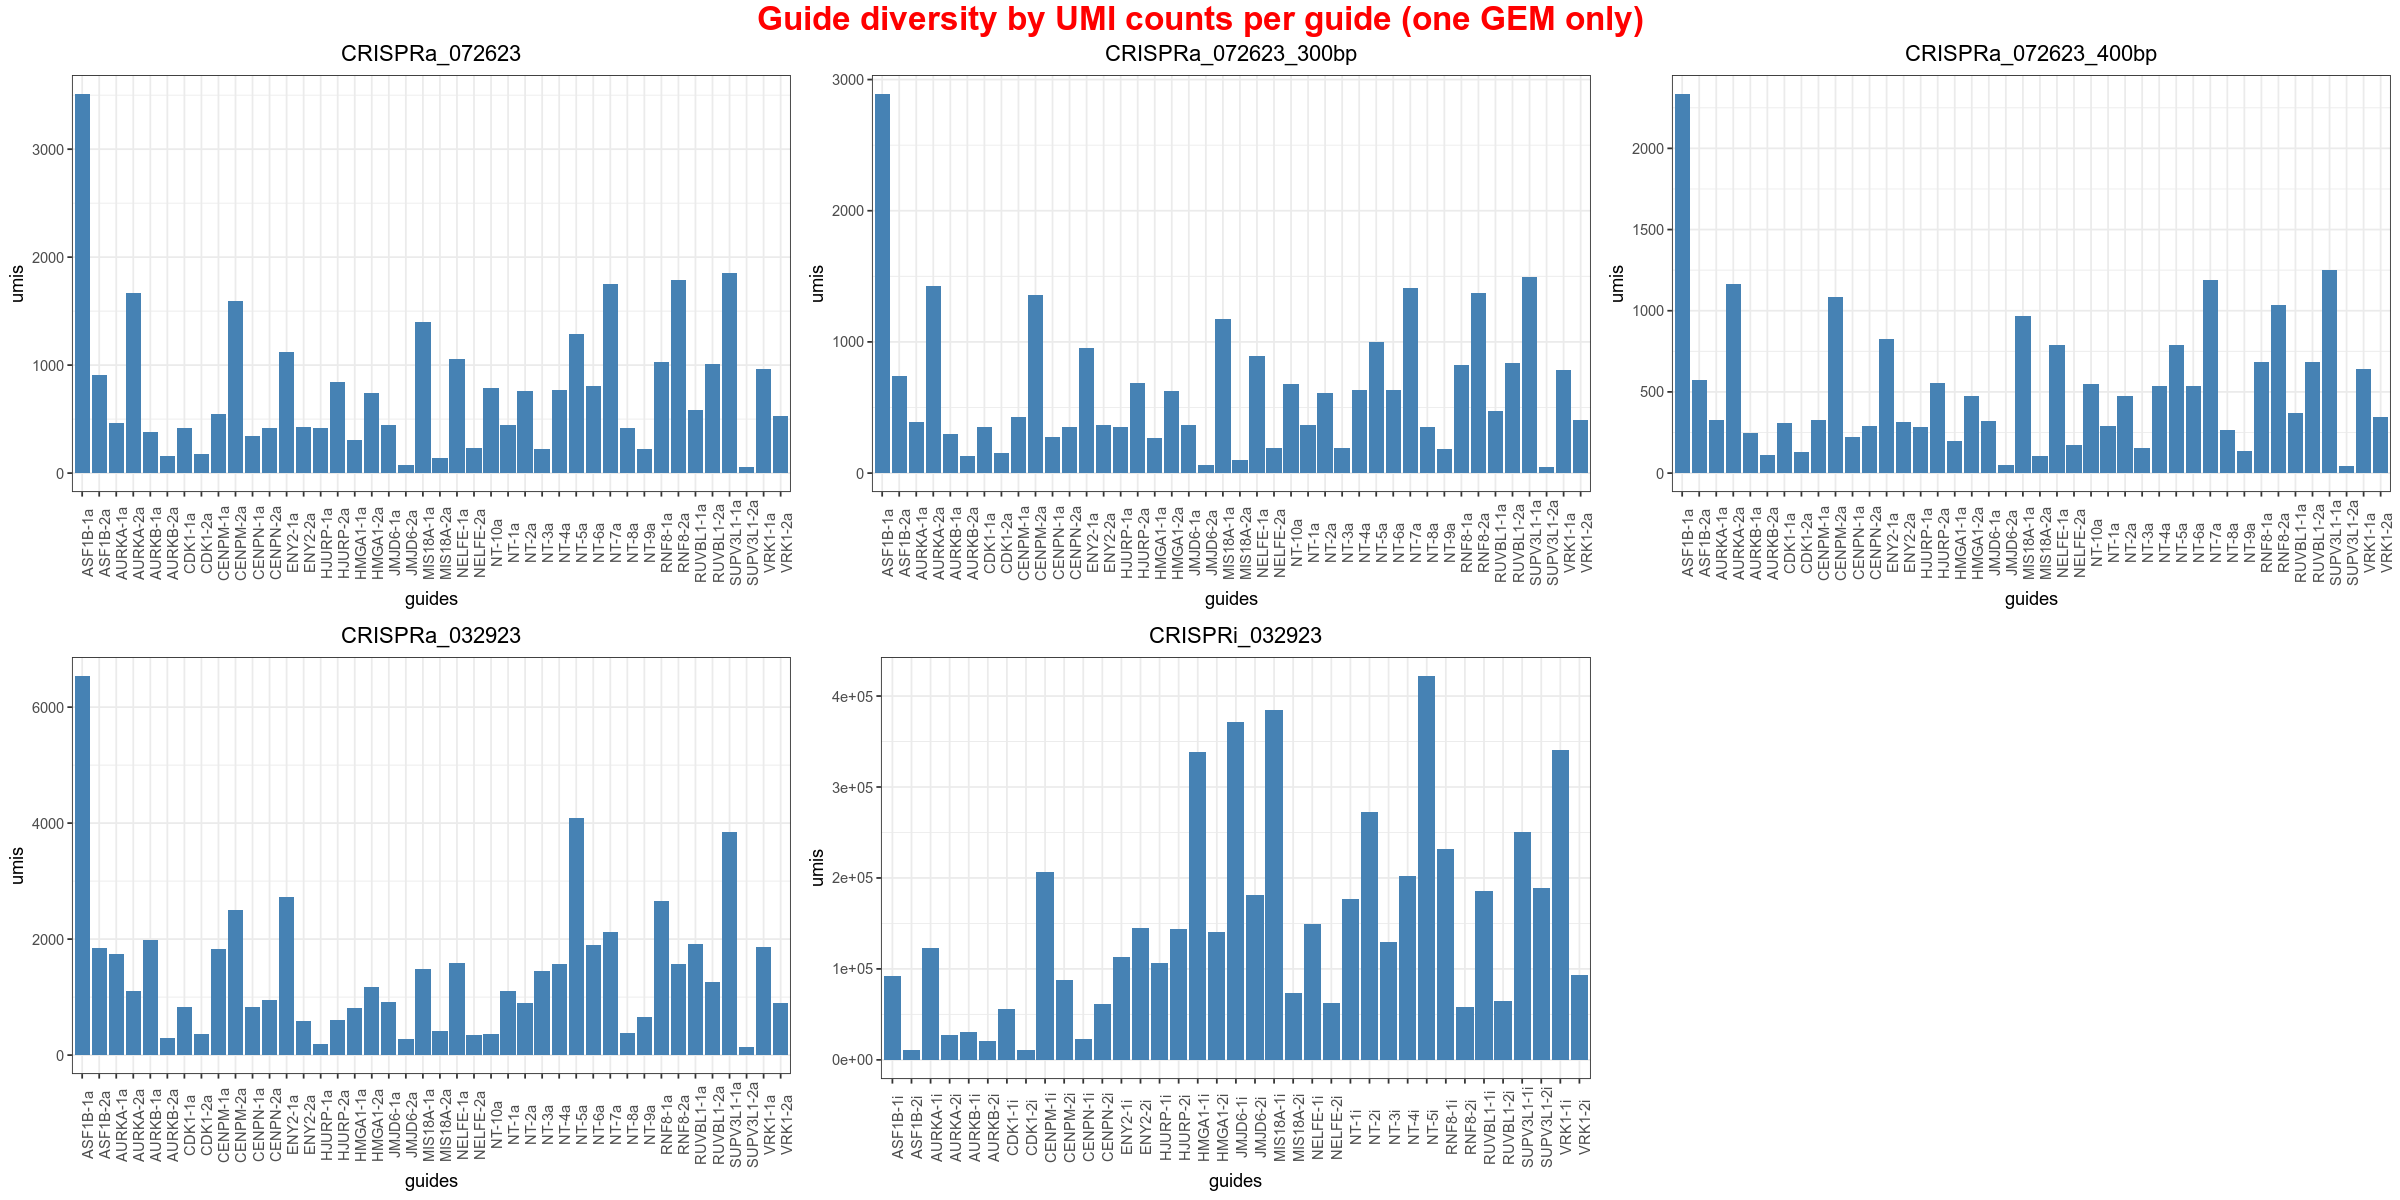

In [7]:
options(repr.plot.width = 20, repr.plot.height = 10)
library(ggplot2)
library(ggpubr)
umis_by_guide_plots = list()
for (i in 1:length(total_umis_per_guide)) {
    umis_by_guide_plots[[i]] = ggplot(data=total_umis_per_guide[[i]], aes(x=guides, y=umis)) +
        geom_bar(stat="identity", fill="steelblue") +
        theme_bw() + ggtitle(names(total_umis_per_guide)[i]) + theme(axis.text.x = element_text(angle = 90), plot.title = element_text(hjust = 0.5))
}
umis_by_guide_plot = ggarrange(plotlist = umis_by_guide_plots)
suppressMessages(annotate_figure(umis_by_guide_plot, top = text_grob("Guide diversity by UMI counts per guide (one GEM only)", 
               color = "red", face = "bold", size = 20)))

## Guide diversity by # of assigned cells per guide

In [8]:
## load in post geomux data for GEM1

CRISPRa_072623_geomux = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRa_repeat_screen/geomux_output_assignments_CRISPRa.csv')
CRISPRa_072623_300bp_geomux = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRa_repeat_screen_guide_fraction_miseq_300bp/geomux_output_assignments_CRISPRa.csv')
CRISPRa_072623_400bp_geomux = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRa_repeat_screen_guide_fraction_miseq_400bp/geomux_output_assignments_CRISPRa.csv')
CRISPRa_032923_geomux = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/geomux_output_assignments_CRISPRa_GEM3_only.csv')
CRISPRi_032923_geomux = read.csv('/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRi_CRISPRa_cell_culture_screen/geomux_output_assignments_CRISPRi_GEM1_only.csv')

guide_fractions_geomux = list(CRISPRa_072623_geomux, CRISPRa_072623_300bp_geomux, CRISPRa_072623_400bp_geomux, CRISPRa_032923_geomux, CRISPRi_032923_geomux)
names(guide_fractions_geomux) = c('CRISPRa_072623', 'CRISPRa_072623_300bp', 'CRISPRa_072623_400bp', 'CRISPRa_032923', 'CRISPRi_032923')


In [9]:
cell_number_per_guide = lapply(guide_fractions_geomux, function(x) table(x$guide))
cell_number_per_guide = lapply(cell_number_per_guide, function(x) df = data.frame(guide = names(x), count = as.numeric(x)))

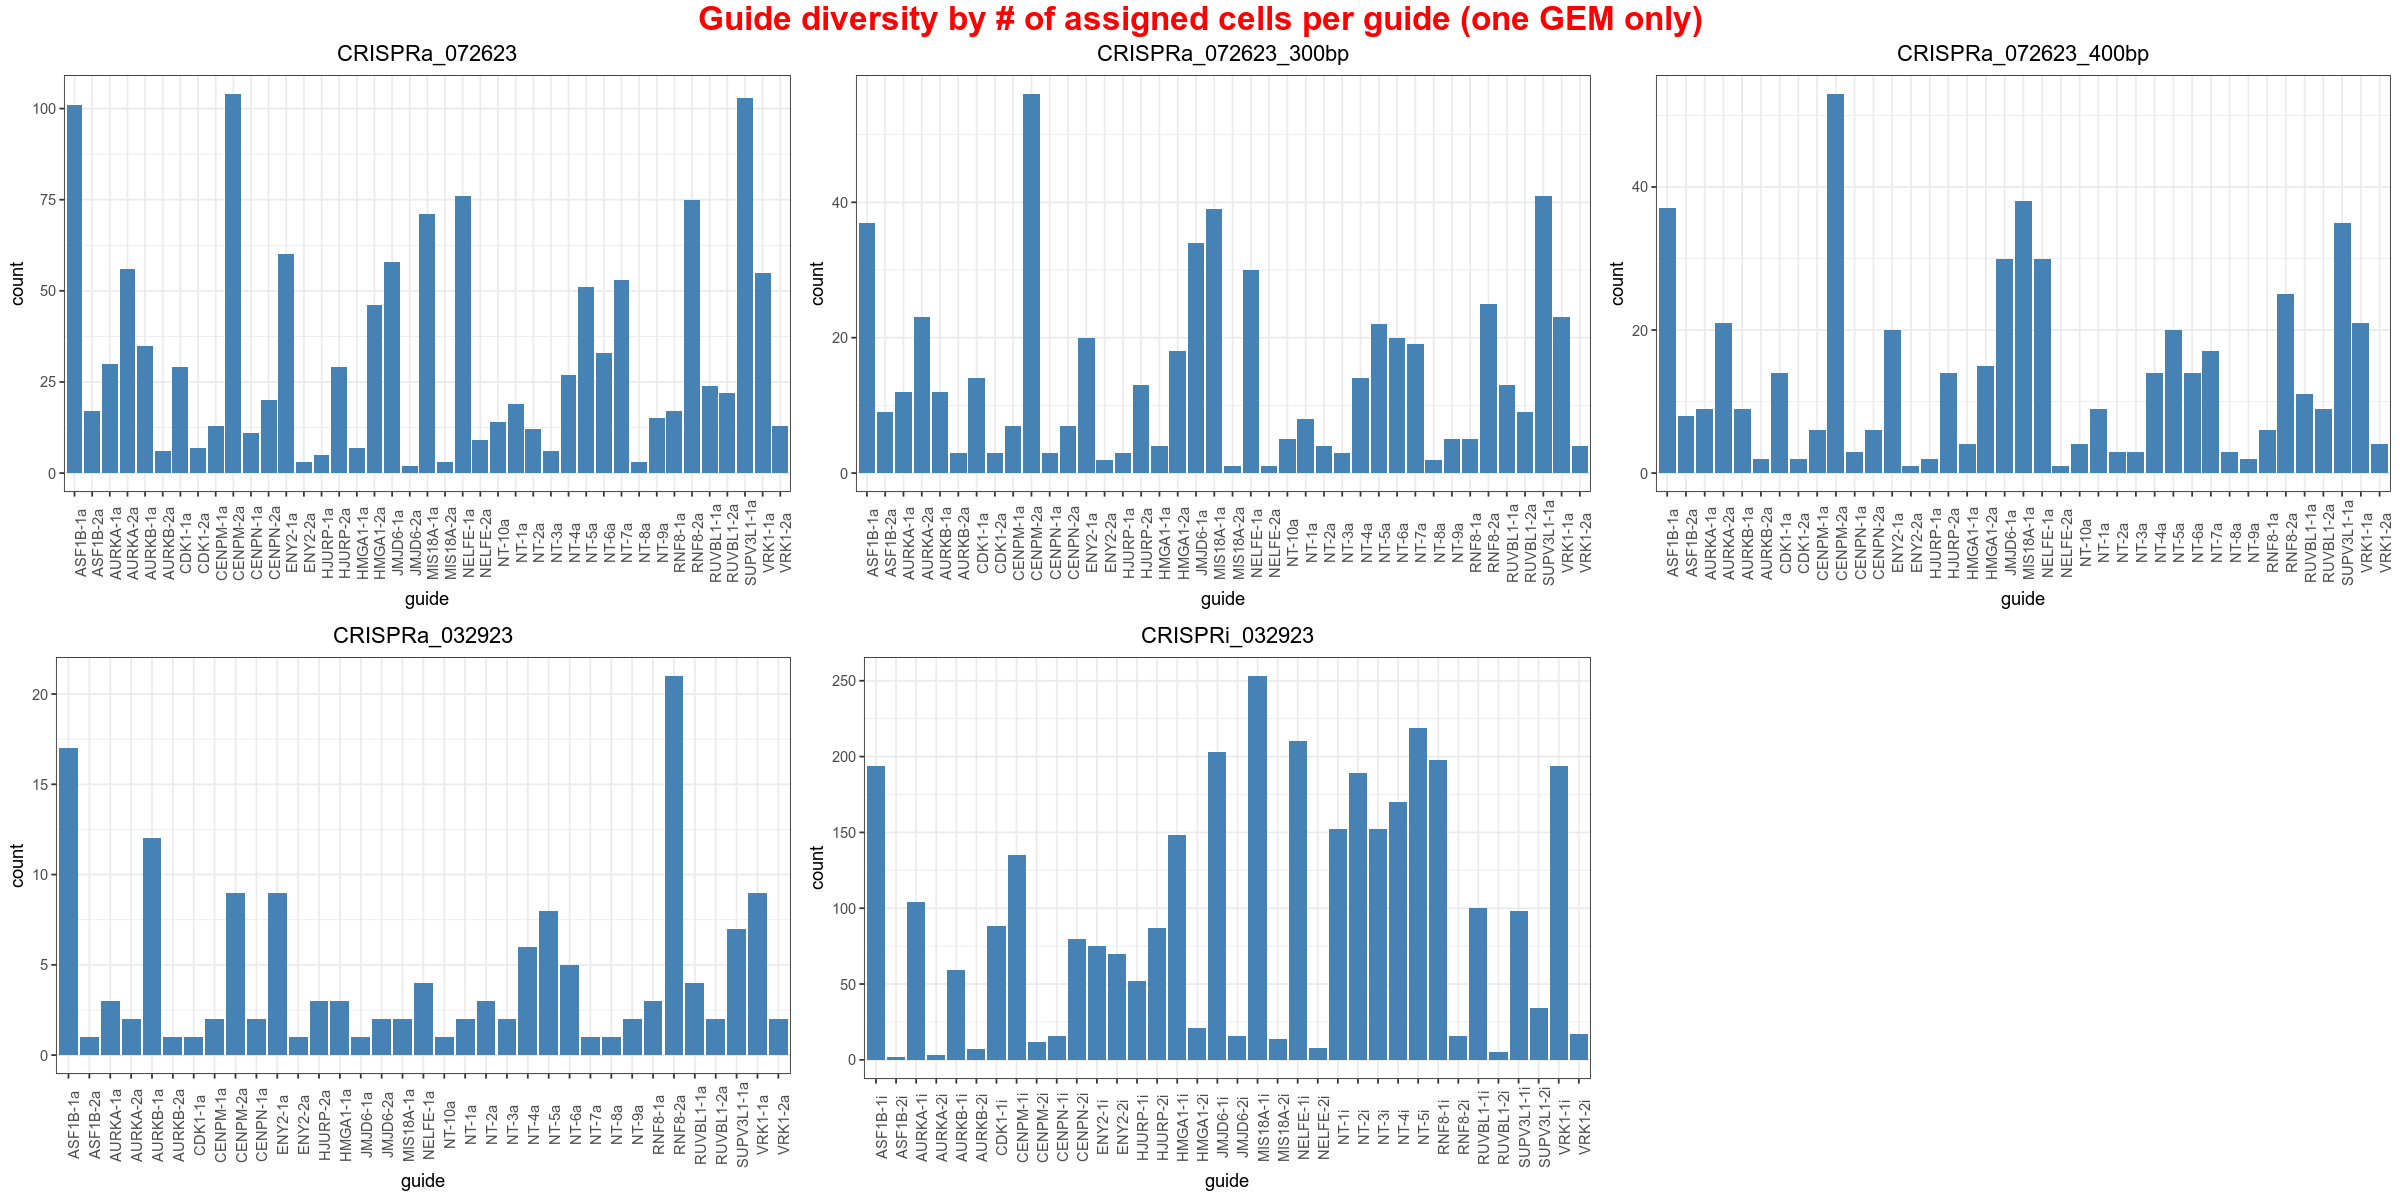

In [10]:
options(repr.plot.width = 20, repr.plot.height = 10)
library(ggplot2)
library(ggpubr)
cell_number_per_guide_plots = list()
for (i in 1:length(cell_number_per_guide)) {
    cell_number_per_guide_plots[[i]] = ggplot(data=cell_number_per_guide[[i]], aes(x=guide, y=count)) +
        geom_bar(stat="identity", fill="steelblue") +
        theme_bw() + ggtitle(names(guide_fractions_geomux)[i]) + theme(axis.text.x = element_text(angle = 90), plot.title = element_text(hjust = 0.5))
}
cell_number_per_guide_plot = ggarrange(plotlist = cell_number_per_guide_plots)
suppressMessages(annotate_figure(cell_number_per_guide_plot, top = text_grob("Guide diversity by # of assigned cells per guide (one GEM only)", 
               color = "red", face = "bold", size = 20)))